In [1]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier


import warnings

# 경고 무시
warnings.filterwarnings("ignore", category=FutureWarning)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 예시로 'NanumGothic'을 사용

In [3]:
# train = pd.read_csv("../data/test.csv")
test = pd.read_csv("../data/test.csv")

In [4]:
test = test.drop(['ID'], axis=1)

In [5]:
test

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0
3,14400000,36 months,5 years,MORTGAGE,66000000,13.72,30,신용 카드,1,669024,281724.0,0.0,0.0
4,27600000,36 months,5 years,RENT,55200000,30.50,12,신용 카드,0,1250052,614844.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64192,30000000,36 months,3 years,MORTGAGE,78000000,22.08,27,부채 통합,2,1307532,763380.0,0.0,0.0
64193,30000000,60 months,10+ years,MORTGAGE,109200000,12.06,26,부채 통합,0,960612,1245252.0,0.0,0.0
64194,6120000,36 months,10+ years,RENT,39600000,28.80,33,부채 통합,0,131520,80880.0,0.0,0.0
64195,11520000,36 months,10+ years,MORTGAGE,66000000,25.44,41,부채 통합,1,1339536,601872.0,0.0,0.0


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64197 entries, 0 to 64196
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   대출금액          64197 non-null  int64  
 1   대출기간          64197 non-null  object 
 2   근로기간          64197 non-null  object 
 3   주택소유상태        64197 non-null  object 
 4   연간소득          64197 non-null  int64  
 5   부채_대비_소득_비율   64197 non-null  float64
 6   총계좌수          64197 non-null  int64  
 7   대출목적          64197 non-null  object 
 8   최근_2년간_연체_횟수  64197 non-null  int64  
 9   총상환원금         64197 non-null  int64  
 10  총상환이자         64197 non-null  float64
 11  총연체금액         64197 non-null  float64
 12  연체계좌수         64197 non-null  float64
dtypes: float64(4), int64(5), object(4)
memory usage: 6.4+ MB


In [7]:
label_encoder = LabelEncoder()

test['대출기간'] = label_encoder.fit_transform(test['대출기간'])
test['대출목적'] = label_encoder.fit_transform(test['대출목적'])
test['주택소유상태'] = label_encoder.fit_transform(test['주택소유상태'])

In [8]:
# test[test['근로기간'] == '10+years']['근로기간'] = '10+ years'
test.loc[test['근로기간'] == '10+years','근로기간'] = '10+ years'
test.loc[test['근로기간'] == '<1 year','근로기간'] = '< 1 year'
test.loc[test['근로기간'] == '1 years','근로기간'] = '1 year'
test.loc[test['근로기간'] == '3','근로기간'] = '3 years'
test.loc[test['근로기간'] == 'Unknown','근로기간'] = 0
test.loc[test['근로기간'] == '1 year','근로기간'] = 1
test.loc[test['근로기간'] == '2 years','근로기간'] = 1
test.loc[test['근로기간'] == '3 years','근로기간'] = 2
test.loc[test['근로기간'] == '4 years','근로기간'] = 2
test.loc[test['근로기간'] == '5 years','근로기간'] =2
test.loc[test['근로기간'] == '6 years','근로기간'] = 3
test.loc[test['근로기간'] == '7 years','근로기간'] = 3
test.loc[test['근로기간'] == '8 years','근로기간'] =3
test.loc[test['근로기간'] == '9 years','근로기간'] = 3
test.loc[test['근로기간'] == '10+ years','근로기간'] = 4
test.loc[test['근로기간'] == '< 1 year','근로기간'] = 1



test['대출기간'] = test['대출기간'].astype('category')
test['주택소유상태'] =  test['주택소유상태'].astype('category')
test['대출목적'] =  test['대출목적'].astype('category')
test['근로기간']= test['근로기간'].astype(float)

In [57]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64197 entries, 0 to 64196
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   대출금액          64197 non-null  int64   
 1   대출기간          64197 non-null  category
 2   근로기간          64197 non-null  float64 
 3   주택소유상태        64197 non-null  category
 4   연간소득          64197 non-null  int64   
 5   부채_대비_소득_비율   64197 non-null  float64 
 6   총계좌수          64197 non-null  int64   
 7   대출목적          64197 non-null  category
 8   최근_2년간_연체_횟수  64197 non-null  int64   
 9   총상환원금         64197 non-null  int64   
 10  총상환이자         64197 non-null  float64 
 11  총연체금액         64197 non-null  float64 
 12  연체계좌수         64197 non-null  float64 
dtypes: category(3), float64(5), int64(5)
memory usage: 5.1 MB


ValueError: Could not interpret value `대출등급` for `x`. An entry with this name does not appear in `data`.

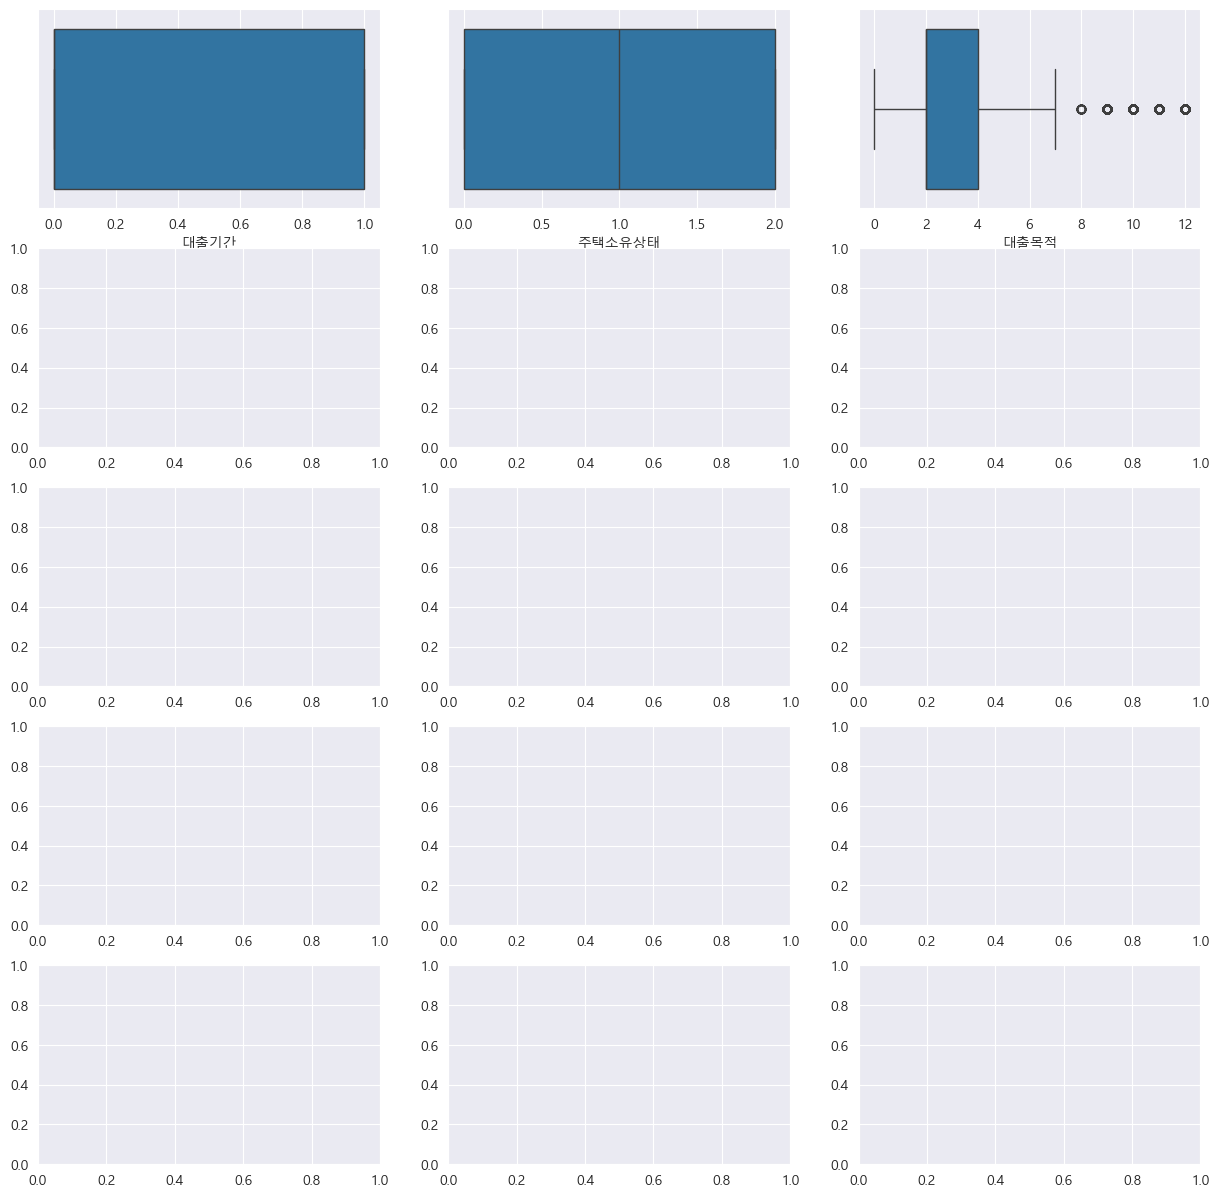

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 열 리스트
numeric_cols = ['대출기간', '주택소유상태','대출목적','대출등급','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                '연체계좌수']

# 4x3 박스플롯 그리기
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
a = 0

# 각각의 subplot에 박스플롯 그리기
for i in range(4):
    for j in range(3):
        if a < len(numeric_cols):
            sns.boxplot(x=numeric_cols[a], data=test, ax=axes[i, j])
            a += 1
        else:
            axes[i, j].set_visible(False)  # 비어있는 서브플롯 숨기기

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [ ]:
# 4x3 히스토그램 그리기
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
a = 0
numeric_cols = ['대출기간', '주택소유상태','대출목적','대출등급','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                '연체계좌수']

# 각각의 subplot에 히스토그램 그리기
for i in range(4):
    for j in range(3):
        if a < len(numeric_cols):
            axes[i, j].hist(test[numeric_cols[a]], bins=30)
            axes[i, j].set_title(numeric_cols[a])
            a += 1
        else:
            axes[i, j].set_visible(False)  # 비어있는 서브플롯 숨기기

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [58]:
import numpy as np

# 로그 변환 적용
test['연간소득'] = np.log1p(test['연간소득'])
test['부채_대비_소득_비율'] = np.log1p(test['부채_대비_소득_비율'])
test['총상환원금'] = np.log1p(test['총상환원금'])
test['총상환이자'] = np.log1p(test['총상환이자'])
test['총연체금액'] = np.log1p(test['총연체금액'])
test['총계좌수'] = np.log1p(test['총계좌수'])
test['총연체금액'] = np.log1p(test['총연체금액'])
test['최근_2년간_연체_횟수'] = np.log1p(test['최근_2년간_연체_횟수'])


KeyError: '대출등급'

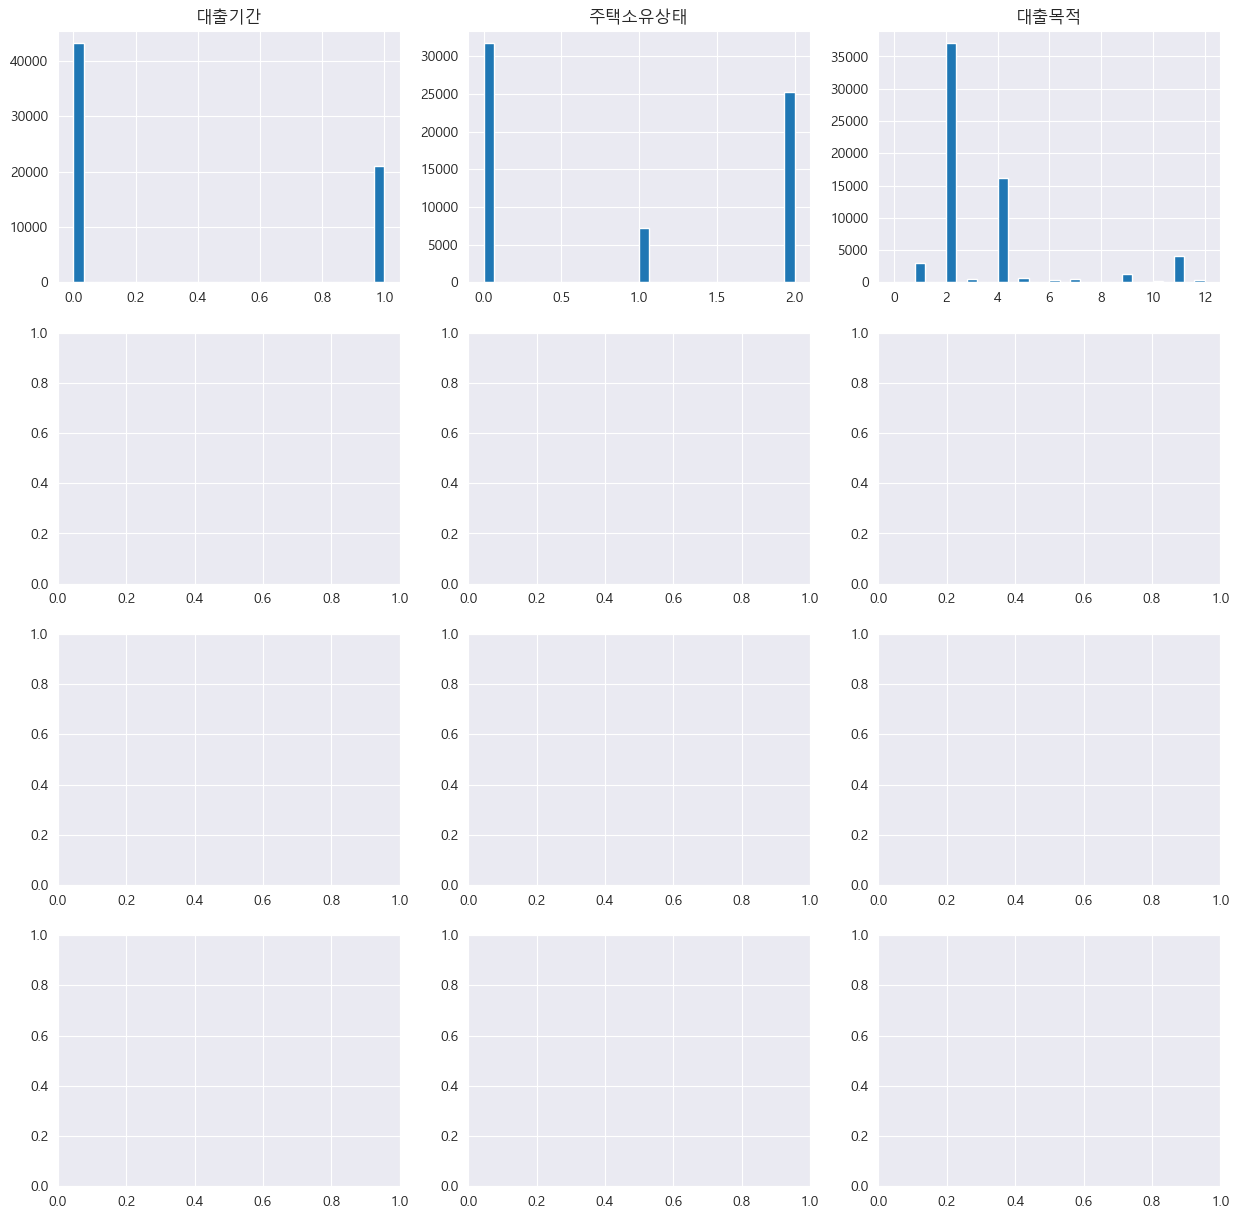

In [26]:
# 4x3 히스토그램 그리기
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
a = 0
numeric_cols = ['대출기간', '주택소유상태','대출목적','대출등급','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                '연체계좌수']

# 각각의 subplot에 히스토그램 그리기
for i in range(4):
    for j in range(3):
        if a < len(numeric_cols):
            axes[i, j].hist(test[numeric_cols[a]], bins=30)
            axes[i, j].set_title(numeric_cols[a])
            a += 1
        else:
            axes[i, j].set_visible(False)  # 비어있는 서브플롯 숨기기

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [12]:
pred = test[test['근로기간'] == -999]
pred.drop('근로기간', axis = 1 ,inplace = True)

C:\Users\SJ\AppData\Local\Temp\ipykernel_38696\4096017740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred.drop('근로기간', axis = 1 ,inplace = True)


In [13]:
test_1 = test[test['근로기간'] != -999]

In [14]:
X_test1 = test_1.drop('근로기간',axis=1)
X_test1

,대출금액,대출기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,근로기간_unknown
0,16800000,0,0,18.698312,3.027231,2.564949,11,0,12.885864,11.895497,0.0,0.0,0
1,8400000,0,2,18.315000,2.823757,3.258097,2,0,0.000000,0.000000,0.0,0.0,0
2,17280000,0,2,18.826146,2.241773,3.044522,4,0,14.396038,12.549027,0.0,0.0,0
3,14400000,0,0,18.005165,2.689207,3.433987,4,1,13.413577,12.548687,0.0,0.0,0
4,27600000,0,2,17.826474,3.449988,2.564949,4,0,14.038697,13.329125,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64192,30000000,0,0,18.172219,3.138966,3.332205,2,2,14.083653,13.545513,0.0,0.0,0
64193,30000000,1,0,18.508692,2.569554,3.295837,2,0,13.775327,14.034849,0.0,0.0,0
64194,6120000,0,2,17.494340,3.394508,3.526361,2,0,11.786922,11.300734,0.0,0.0,0
64195,11520000,0,0,18.005165,3.274878,3.737670,2,1,14.107835,13.307802,0.0,0.0,0


In [15]:
y_test1 = test_1['근로기간']
y_test1

0         8.0
1         5.0
2         6.0
3         5.0
4         5.0
         ... 
64192     3.0
64193    15.0
64194    15.0
64195    15.0
64196     9.0
Name: 근로기간, Length: 60335, dtype: float64

In [16]:
# 훈련 세트와 검증 세트로 나누기 (비율 80:20)
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test1, y_test1, test_size=0.2, random_state=42)

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64197 entries, 0 to 64196
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   대출금액          64197 non-null  int64   
 1   대출기간          64197 non-null  category
 2   근로기간          64197 non-null  float64 
 3   주택소유상태        64197 non-null  category
 4   연간소득          64197 non-null  float64 
 5   부채_대비_소득_비율   64197 non-null  float64 
 6   총계좌수          64197 non-null  float64 
 7   대출목적          64197 non-null  category
 8   최근_2년간_연체_횟수  64197 non-null  int64   
 9   총상환원금         64197 non-null  float64 
 10  총상환이자         64197 non-null  float64 
 11  총연체금액         64197 non-null  float64 
 12  연체계좌수         64197 non-null  float64 
 13  근로기간_unknown  64197 non-null  category
dtypes: category(4), float64(8), int64(2)
memory usage: 5.1 MB


In [18]:
# 범주형 특성의 열 인덱스를 찾습니다.
cat_features_index = [X_test.columns.get_loc(col) for col in ['대출기간', '주택소유상태', '대출목적','근로기간_unknown']]

# CatBoost 분류 모델을 생성하고 훈련합니다.
cat_model = CatBoostRegressor(silent=True, iterations=100, cat_features=cat_features_index)
cat_model.fit(X_test, y_test)

In [19]:
cat_predictions = cat_model.predict(X_valid)

In [20]:
# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(y_valid, cat_predictions)

# R^2 (결정 계수) 계산
r2 = r2_score(y_valid, cat_predictions)

print(f"MAE: {mae}")
print(f"R^2: {r2}")

MAE: 5.068022402666739
R^2: 0.04822360982613649


In [194]:
# 랜덤 포레스트 회귀 모델을 생성합니다.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # n_estimators는 모델에 사용할 트리의 개수입니다.

# 모델을 훈련 데이터에 맞춥니다.
rf_model.fit(X_test, y_test)

RandomForestRegressor(random_state=42)

In [195]:
# 검증 데이터에 대한 예측을 수행합니다.
rf_predictions = rf_model.predict(X_valid)

# 평균 절대 오차 (MAE)를 계산합니다.
rf_mae = mean_absolute_error(y_valid, rf_predictions)

# 결정 계수 (R^2)를 계산합니다.
rf_r2 = r2_score(y_valid, rf_predictions)

print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest R^2: {rf_r2}")

Random Forest MAE: 5.118625103448276
Random Forest R^2: 0.02001072823987604


In [198]:
len(y_valid)

18125

In [199]:
type(y_valid)

pandas.core.series.Series

In [202]:
type(rf_predictions)

numpy.ndarray

In [203]:
series = pd.Series(7.75, index=range(18125))

In [205]:
# 평균 절대 오차 (MAE)를 계산합니다.
rf_mae = mean_absolute_error(y_valid, series)

# 결정 계수 (R^2)를 계산합니다.
rf_r2 = r2_score(y_valid, series)

print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest R^2: {rf_r2}")

Random Forest MAE: 5.262
Random Forest R^2: -1.1269692830495615e-05


In [21]:
predicted_values_rainfall = cat_model.predict(pred)

In [22]:
predicted_values_rainfall

array([11.51039679,  6.34337126,  5.53073507, ...,  7.12872393,
        9.94652302,  4.82002501])

In [23]:
test.loc[test['근로기간'] == -999, '근로기간'] = predicted_values_rainfall

In [59]:
test

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,16800000,0,3.0,0,18.698312,3.027231,2.564949,11,0.000000,12.885864,11.895497,0.0,0.0
1,8400000,0,2.0,2,18.315000,2.823757,3.258097,2,0.000000,0.000000,0.000000,0.0,0.0
2,17280000,0,3.0,2,18.826146,2.241773,3.044522,4,0.000000,14.396038,12.549027,0.0,0.0
3,14400000,0,2.0,0,18.005165,2.689207,3.433987,4,0.693147,13.413577,12.548687,0.0,0.0
4,27600000,0,2.0,2,17.826474,3.449988,2.564949,4,0.000000,14.038697,13.329125,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64192,30000000,0,2.0,0,18.172219,3.138966,3.332205,2,1.098612,14.083653,13.545513,0.0,0.0
64193,30000000,1,4.0,0,18.508692,2.569554,3.295837,2,0.000000,13.775327,14.034849,0.0,0.0
64194,6120000,0,4.0,2,17.494340,3.394508,3.526361,2,0.000000,11.786922,11.300734,0.0,0.0
64195,11520000,0,4.0,0,18.005165,3.274878,3.737670,2,0.693147,14.107835,13.307802,0.0,0.0


In [9]:
test.to_csv('../data/test_preprocessing_test.csv', index=False)